In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable
from enum import IntEnum

In [2]:
class Action(IntEnum):
    """Action"""

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3


The class Action uses IntEnum to define enumerated constants as integers It assigns the LEFT action to the value 0 and so on

In [3]:
def actions_to_dxdy(action: Action):
    """
    Helper function to map action to changes in x and y coordinates

    Args:
        action (Action): taken action

    Returns:
        dxdy (Tuple[int, int]): Change in x and y coordinates
    """
    mapping = {
        Action.LEFT: (-1, 0),
        Action.DOWN: (0, -1),
        Action.RIGHT: (1, 0),
        Action.UP: (0, 1),
    }
    return mapping[action]

This maps the action to the change in the (x,y) coordinates that help in determining the necessary states

Associates each possible action to the Action enumeration obtained from the mapping dictionary

Given a coordinate (2,3) ; if it performs an Action.LEFT it is supposed to move one step to the left of x and no change in y

In [4]:
def reset():
    """Return agent to start state"""
    return (0, 0)

**Implement a simulate function that acts as the Four Rooms environment.
It should take in the current state s and desired action a, and return the next state s′ as well as the reward r**

In [5]:
def simulate(state: Tuple[int, int], action: Action):
    """Simulate function for Four Rooms environment

    Implements the transition function p(next_state, reward | state, action).
    The general structure of this function is:
        1. If goal was reached, reset agent to start state
        2. Calculate the action taken from selected action (stochastic transition)
        3. Calculate the next state from the action taken (accounting for boundaries/walls)
        4. Calculate the reward

    Args:
        state (Tuple[int, int]): current agent position (e.g. (1, 3))
        action (Action): selected action from current agent position (must be of type Action defined above)

    Returns:
        next_state (Tuple[int, int]): next agent position
        reward (float): reward for taking action in state
    """
    # Walls
    # Coordinate system is (x, y) where x is the horizontal and y is the vertical direction
    walls = [
        (0, 5),
        (2, 5),
        (3, 5),
        (4, 5),
        (5, 0),
        (5, 2),
        (5, 3),
        (5, 4),
        (5, 5),
        (5, 6),
        (5, 7),
        (5, 9),
        (5, 10),
        (6, 4),
        (7, 4),
        (9, 4),
        (10, 4),
    ]



    # TODO check if goal was reached
    goal_state = (10, 10)

    # 1. If goal was reached, reset agent to start state
    if state==goal_state:
        # Teleport the agent back to the start state
        return reset(),0

    # 2. Calculate the action taken from selected action (stochastic transition)
    action_taken=action

    # Generate noise
    # 90% of the time the agent takes correct action ; 10% of the time the agent slips and moves in the perpendicular direction

    if np.random.rand() < 0.1:
    # Thus if the random number generated is less than 0.1 the noisy action occurs leading to the agent slipping in the perpendicular direction
    # With 10% probability, take a perpendicular action
      action_taken = np.random.choice([a for a in Action if a != action])
    # The actions from Action enumeration are considered that are not equal to the current action
    # Thus x!= action
    dx, dy = actions_to_dxdy(action_taken)

    # 3. Calculate the next state from the action taken (accounting for boundaries/walls)
    nextstate_x,nextstate_y = state[0] + dx, state[1] + dy
    # Calculates the next x and y coordinates by adding the calculated dx (change in x) and dy (change in y) to the current x and y coordinates

    if (nextstate_x, nextstate_y) not in walls and 0 <= nextstate_x <= 10 and 0 <= nextstate_y <=10:
        next_state = (nextstate_x, nextstate_y)
    else:
      # If the noisy action causes collision into the wall,or takes the agent out of bounds, then the state does not change
        next_state = state

    # 4. Calculate the reward
    # Resulting state == Goal state ; reward is +1 otherwise reward 0
    if next_state==goal_state:
          reward =1
    else:
          reward=0

    return next_state,reward


In [6]:
# Here when the action Left is taken the agent move to the left and there is no change in y direction
state = (2, 3)
action = Action.LEFT
next_state, reward = simulate(state, action)
if next_state is not None and reward is not None:
    print(f"Next state {next_state}, Reward {reward}")

Next state (1, 3), Reward 0


In [7]:
# Current state is the goal state and not the resulting state . Hence the reward is 0
state = (10, 10)
action = Action.LEFT
next_state, reward = simulate(state, action)
if next_state is not None and reward is not None:
    print(f"Next state {next_state}, Reward {reward}")


Next state (0, 0), Reward 0


In [8]:
# When taken the action Right , the resulting state is goal state.Hence the reward is +1
state = (9, 10)
action = Action.RIGHT
next_state, reward = simulate(state, action)
if next_state is not None and reward is not None:
    print(f"Next state {next_state}, Reward {reward}")

Next state (10, 10), Reward 1


**Implement a manual policy, and an agent that interacts with the simulator and the policy.**

In [9]:
def manual_policy(state: Tuple[int, int]):
    """A manual policy that queries user for action and returns that action

    Args:
        state (Tuple[int, int]): current agent position (e.g. (1, 3))

    Returns:
        action (Action)
    """
    # TODO
    while True:
      print(f'Current state:{state}')
      action=int(input("Action : LEFT-0; DOWN-1;RIGHT-2;UP-3"))
      if action in range(4):
        return Action(action)
      else:
        print('Invalid Action')


In [10]:
action_chosen= manual_policy((10,10))
print(action_chosen)


Current state:(10, 10)
Action : LEFT-0; DOWN-1;RIGHT-2;UP-33
Action.UP


In [11]:
action_chosen= manual_policy((5,3))
print(action_chosen)

Current state:(5, 3)
Action : LEFT-0; DOWN-1;RIGHT-2;UP-31
Action.DOWN


**Implement an Agent**

In [12]:
import matplotlib.pyplot as plt

def agent(
    steps: int = 1000,
    trials: int = 1,
    policy=Callable[[Tuple[int, int]], Action],
    policy_name: str = "Policy"
):
    """
    An agent that provides actions to the environment (actions are determined by policy), and receives
    next_state and reward from the environment

    The general structure of this function is:
        1. Loop over the number of trials
        2. Loop over total number of steps
        3. While t < steps
            - Get action from policy
            - Take a step in the environment using simulate()
            - Keep track of the reward
        4. Compute cumulative reward of trial

    Args:
        steps (int): steps
        trials (int): trials
        policy: a function that represents the current policy. Agent follows policy for interacting with environment.
            (e.g. policy=manual_policy, policy=random_policy)

    """
    policy_names=['Manual Policy','Random policy','Worse Policy','Better Policy']
    # TODO you can use the following structure and add to it as needed
    cumulative_rewards=[]

    for t in range(trials):
        state = reset()
        i = 0
        # Initialize the cumulative reward
        cumulative_reward=0
        reward_list=[]
        while i < steps:
            # TODO select action to take
            action = policy(state)
            # TODO take step in environment using simulate()
            next_state,reward=simulate(state,action)
            # TODO Keep track of the reward
            cumulative_reward=cumulative_reward+reward
            reward_list.append(cumulative_reward)
            # Update current state to next state
            state=next_state
            i=i+1


        cumulative_rewards.append(reward_list)



    # Calculate the average cumulative reward across all trials
    average_reward = np.mean(np.array(cumulative_rewards), axis=0)

    # Plot cumulative reward curves for each trial
    for i in range(trials):
        plt.plot(range(1, steps + 1), cumulative_rewards[i], linestyle='dotted',label=f'Trial {t + 1}')

    # Plot the average cumulative reward curve
    plt.plot(range(1, steps + 1), average_reward, linewidth=3, color='black', label='Average')

    plt.title(f'Cumulative Reward Curve for {policy_name} Policy')

    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.legend(fontsize=10)
    plt.show()


In [ ]:
# Checking manual policy by runnin the agent
# agent(steps=10,trails=1,policy=manual_policy,policy_name='Manual')

**Implement a random policy. A random policy outputs one of the four actions, uniformly at
random**

In [14]:
def random_policy(state: Tuple[int, int]):
  while True:
    return np.random.choice(list(Action))

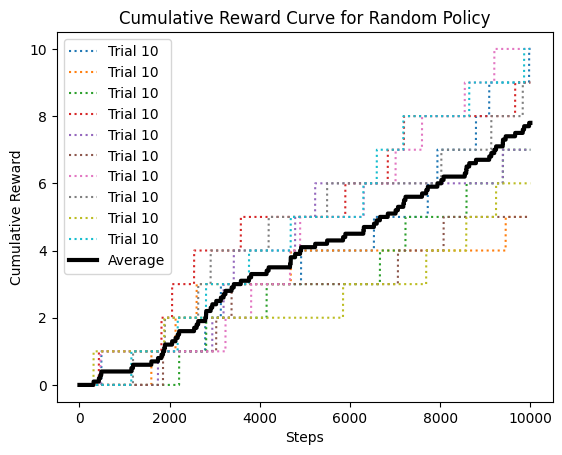

In [15]:
# Run the agent
agent(steps=10000, trials=10, policy=random_policy,policy_name='Random')


**Devise and implement at least two more policies, one of which should be generally worse than
the random policy, and one better**

**Worse Policy**

**Worse policy : In comparison to the random policy , the worse policy should be defined such that it is worse than the random  policy**



In [16]:
def worse_policy(state: Tuple[int, int]):
    """A policy that is worse than the random_policy

    Args:
        state (Tuple[int, int]): current agent position (e.g. (1, 3))

    Returns:
        action (Action)
    """
    # TODO
    # One can deduce that to reach the goal state from an initial state
    # the best possible acions would be UP and RIGHT by looking at the given environment
    # Thus,define the probabilities for each action
    # Assign higher probabilities to LEFT and DOWN
    worse_probabilities = [0.3, 0.3, 0.2, 0.2]

   # Choose an action based on the probabilities
    action = np.random.choice(list(Action), p=worse_probabilities)

    return action


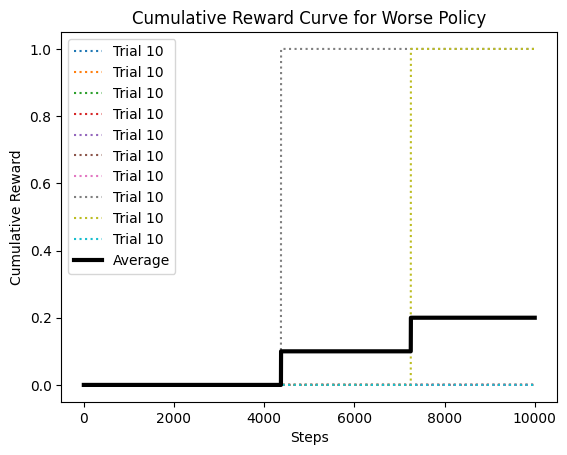

In [17]:
# Run the agent
agent(steps=10000,trials=10,policy=worse_policy,policy_name='Worse')

**Better Policy**

In [18]:
def better_policy(state: Tuple[int, int]):
    """A policy that is worse than the random_policy

    Args:
        state (Tuple[int, int]): current agent position (e.g. (1, 3))

    Returns:
        action (Action)
    """
    # TODO
    # One can deduce that to reach the goal state from an initial state
    # the best possible acions would be UP and RIGHT by looking at the given environment
    # Thus,define the probabilities for each action
    # Assign higher probabilities to UP and RIGHT
    better_probabilities = [0.1, 0.1, 0.4, 0.4]

   # Choose an action based on the probabilities
    action = np.random.choice(list(Action), p=better_probabilities)

    return action


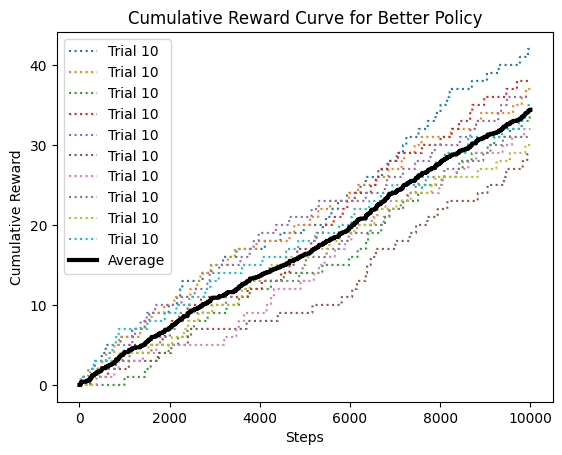

In [19]:
agent(steps=10000,trials=10,policy=better_policy,policy_name='Better')

**Cumulative Reward for all policies plotted together**

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def agent(steps, trials, policy):
    cumulative_rewards = []

    for t in range(trials):
        state = reset()
        i = 0
        cumulative_reward = 0
        reward_list = []

        while i < steps:
            action = policy(state)
            next_state, reward = simulate(state, action)
            cumulative_reward += reward
            reward_list.append(cumulative_reward)
            state = next_state
            i += 1

        cumulative_rewards.append(reward_list)

    return cumulative_rewards

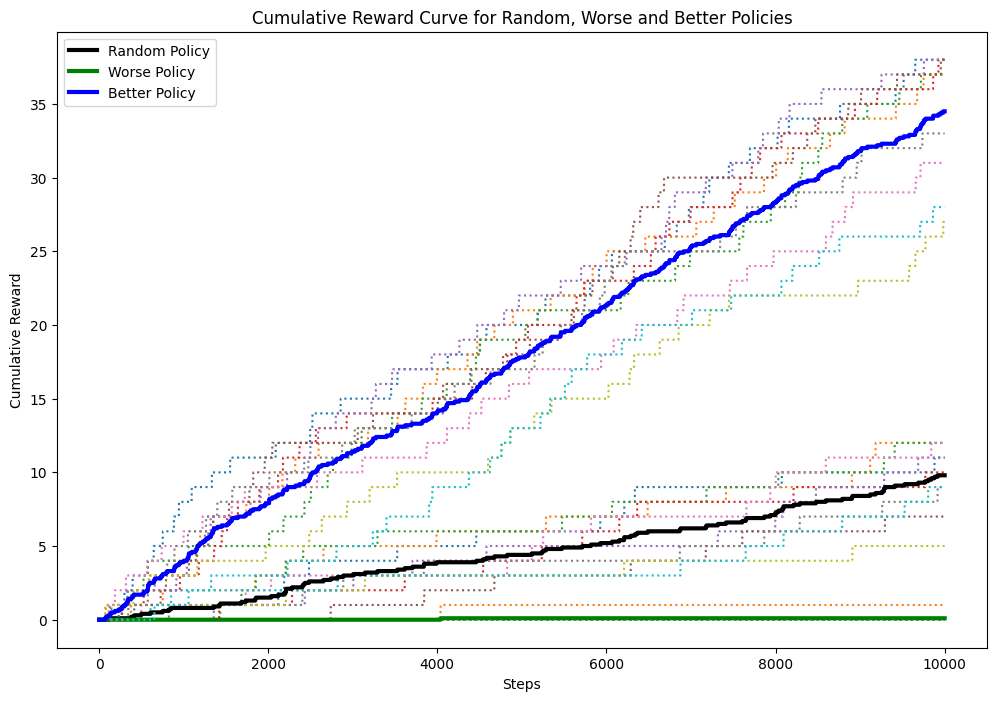

In [21]:
def main():
    # Define the number of trials and steps
    steps = 10000
    trials = 10

    plt.figure(figsize=(12, 8))

    # Create a list to store the policies and their labels
    policies = [random_policy, worse_policy, better_policy]
    # Loop through the labels in order to map each curve to the given colour
    labels = ['Random Policy', 'Worse Policy', 'Better Policy']

    # Loop over each policy
    for i, policy in enumerate(policies):
        cumulative_rewards = agent(steps=steps, trials=trials, policy=policy)

        # Calculate and plot the average cumulative reward as a solid line
        average_reward = np.mean(cumulative_rewards, axis=0)
        # Add colors for each policy
        average_reward_colors = ['Black', 'Green', 'Blue']

        # Plot cumulative reward curves for each trial with a dotted line
        for t in range(trials):
            plt.plot(range(1, steps + 1), cumulative_rewards[t], linestyle='dotted')

        # Plot the average cumulative reward curve
        plt.plot(range(1, steps + 1), average_reward, label=f'{labels[i]}', color=average_reward_colors[i], linewidth=3)

    # Add labels and legend
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.legend(fontsize=10)
    plt.title('Cumulative Reward Curve for Random, Worse and Better Policies')
    plt.show()

if __name__ == "__main__":
    main()
